[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp451/blob/master/Evaluation.ipynb)

# Model Evaluation and Selection
Once we train our model on our dataset, we may hope that it also works well on unseen data. However, getting the best performance on our data is not a good measure. To keep things simple, let's use `scikit-learn`'s implementation of `Ridge` regression and polynomial features.

In [136]:
import numpy as np
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
from sklearn import datasets, neighbors
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

let's set aside 20% of the examples to test the performance of our model as we change the amount of L2 regularization in Ridge regression using polynomial features.

In [137]:
# #Loading the california housing data set
# x, y = datasets.fetch_california_housing(return_X_y=True)
# (num_instances, num_features) = x.shape
# print(num_instances, num_features)
#define a function for the MSE loss
num_instances = 30
degree = 50
x = np.random.rand(num_instances)
y = np.tanh(x**2) - 10*np.sin(x) #before noise
y += np.random.randn(*x.shape) #adding noise
x = np.atleast_2d(x).T
loss = lambda y, yh: np.mean((y-yh)**2) # np.mean(yh == y) # 
# defining polynomial feature
poly = PolynomialFeatures(degree=10, interaction_only=False)
x = poly.fit_transform(x) # replace x with its polynomial features for convenience


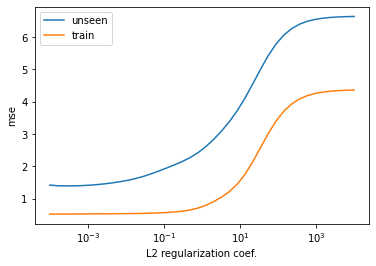

In [138]:
n_test = num_instances // 5
inds = np.random.permutation(num_instances)
x_train, y_train = x[inds[n_test:]], y[inds[n_test:]]
x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]

#Plot the mean square error for different regularization values, stored in reg_list
reg_list = 10 ** np.linspace(-4,4, 40)  
err_train, err_test = [], []
for i, reg in enumerate(reg_list):
    model = Ridge(alpha = reg, fit_intercept=True)
    model = model.fit(x_train, y_train)
    err_test.append(loss(model.predict(x_test), y_test))
    err_train.append(loss(model.predict(x_train), y_train))

plt.plot(reg_list, err_test, '-', label='unseen')
plt.plot(reg_list, err_train, '-', label='train')
plt.xscale('log')
plt.legend()
plt.xlabel('L2 regularization coef.')
plt.ylabel('mse')
plt.show()

The plot above shows that the best model according to our training data is not necessarily the best model when it comes to unseen data. If you rerun the cell with different choices of training and test split, the plot may change considerably. This variance is due to the small size of training and validation sets. We may sometimes even see that the test error is lower than the training error, but as datasets get larger this variance vanishes. Another approach to take this variability across train-test split is using cross-validation that we see shortly. What other observations can we make from the plot above?

## Risk
what we really care about is the performance of the model on new data.
In other words, we want to see how our model **generalizes** to unseen data. 
An assumption that justifies deployment of our model on unseen data is the fact that our training and deployment data come from the *same* distribution. In fact very often we assume that there exists some distribution $p(x,y)$ over our features and labels, such that our training data is composed of independent samples from this distribution -- that is $x^{(n)}, y^{(n)} \sim p(x, y)$ for all $x^{(n)}, y^{(n)} \in \mathcal{D}$. We assume that unseen data are also samples from the same distribution.

**Generalization error** or **risk** is the *expected error* of our model $f: x \mapsto y$ under this distribution:
$$ 
R(f) = \mathbb{E}_{x,y \sim p}[\ell(f(x), y)].
$$
Here $\ell$ is some *loss function* such as classification error $\ell(y, \hat{y}) = \mathbb{I}(y = \hat{y})$ or squared error loss $\ell(y, \hat{y}) = (y - \hat{y})^2$ that we often use in regression.

## Test set
Unfortunately, we don't have access to the true data distribution, we only have samples from this dataset. We can estimate the generalization error by setting aside a portion of our dataset that **we do not use in any way in learning or selecting the model**. This part of the dataset is called the **test set**. Let's use $\mathcal{D}_{\text{train}}$ and $\mathcal{D}_{\text{test}}$ to this partitioning of our original dataset $\mathcal{D}$. The **test error** is
$$
{R}(f; \mathcal{D}_{test}) = \mathbb{E}_{x, y \sim \mathcal{D}_{\text{test}}}[\ell(f(x), y)] = \frac{1}{|\mathcal{D}_{\text{test}}|} \sum_{x,y \in \mathcal{D}_{\text{test}}} \ell(f(x), y).
$$

## Validation set 
Suppose we want to tune the hyper-parameters of our model. We can use a similar idea for picking the best hyper-parameter. Ideally, we want to pick hyper-parameters that give us the best generalization error, or test error. However, it would be a mistake to adjust our model based on the test data; this could lead to overfitting to our test data, which means the performance on the test data is no longer an unbiased estimate of generalization error. So we can set aside another subset of our dataset for doing *model selection*. This is called the *validation set*, or *development set*.

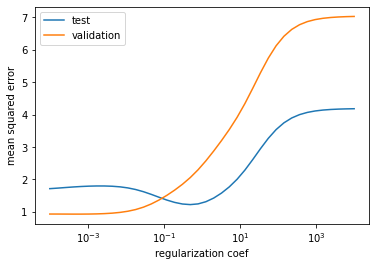

In [139]:
#Split into train, validation and test (8:1:1)
n_test, n_valid = num_instances // 10, num_instances // 10
inds = np.random.permutation(num_instances)
x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
x_valid, y_valid = x[inds[n_test:n_test+n_valid]], y[inds[n_test:n_test+n_valid]]
x_train, y_train = x[inds[n_test+n_valid:]], y[inds[n_test+n_valid:]]

#Plot the mean square error for different K values stored in K_list
err_train, err_test, err_valid = [], [], []
for i, reg in enumerate(reg_list):
    model = Ridge(alpha=reg, fit_intercept=True)
    model = model.fit(x_train, y_train)
    err_test.append(loss(model.predict(x_test), y_test))
    err_valid.append(loss(model.predict(x_valid), y_valid))
    err_train.append(loss(model.predict(x_train), y_train))
    
plt.plot(reg_list, err_test,  label='test')
#plt.plot(K_list, err_train,  label='train')
plt.plot(reg_list, err_valid, label='validation')

plt.legend()
plt.xscale('log')
plt.xlabel('regularization coef')
plt.ylabel('mean squared error')
plt.show()

### Cross validation 
Note that once we pick the best hyper-parameters for our model we can use both train+validation sets to retrain the model. This is only practical if training can be done efficiently.
In the figure above you can notice that validation error can be slightly different from the test error (simply re-run the code). This difference is due to the size of both validation and test sets. We can get a better estimate of the validation error and its variance using **cross validation**: the idea is to repeat the trainin-validation using a different portion of the data. Then we can use the mean and the variance of the training and validation error over these repetitions. For this, it is best to use non-overlapping validation sets: for example use, first we set asign 10% of the data for test. Then a 5-fold cross-validation, would divide the remaining 90% to 5 subsets. At each iteration of cross-validation, one of these 5 subsets will be used for validation and the remaining 4 will be used for training. Once we pick the best model using mean and variance of the validation error, we can train the model using the entire 90% of the data. Finally, we report the performance on the test set. Below we implement a method that returns train and validation split for cross-validation.

In [140]:
def cross_validate(n, n_folds=10):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

Let's first set aside the test data

In [141]:
inds = np.random.permutation(num_instances)
#seperate the test data
x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
x_rest, y_rest = x[inds[n_test:]], y[inds[n_test:]]
#rest for training and validation
n_rest = num_instances - n_test

Then we use cross-validation to find the best set of hyper-parameters

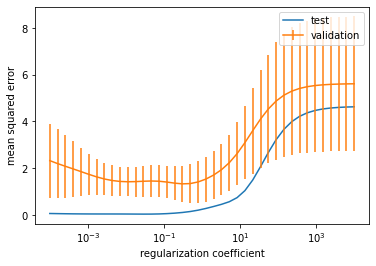

In [142]:
num_folds = 5
err_test, err_valid = np.zeros(len(reg_list)), np.zeros((len(reg_list), num_folds))
for i, reg in enumerate(reg_list):
    #Find the validation errors for num_folds splits for a given K
    for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
        model = Ridge(alpha=reg, fit_intercept=True)
        model = model.fit(x_rest[tr], y_rest[tr])
        err_valid[i, f] = loss(y_rest[val], model.predict(x_rest[val]))
    #this is the part that we don't do in a usual setup. We don't touch the test set until the very end. 
    model = Ridge(alpha=reg, fit_intercept=True)
    model = model.fit(x_rest, y_rest)
    err_test[i]= loss(y_test, model.predict(x_test))
    
plt.plot(reg_list, err_test,  label='test')
plt.errorbar(reg_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
plt.legend()
plt.xscale('log')
plt.xlabel('regularization coefficient')
plt.ylabel('mean squared error')
plt.show()

A simple rule of thumb for picking the best model using cross-validation is to pick the **simplest** model that is within one standard deviation of the best performing model -- e.g., in our example above, we should pick regularization coefficient around $10$. We also see that this choices produces a good performance on the test set, which was not used for hyper-parameter tuning.
What if we have multiple hyper-parameters that should be optimized simultaneously? Some simple solutions are **grid-search** and **random-search** which exhustively or randomly search over joint assignments to hyper-parameters. 

## Evaluation metrics

One could use criteria that are potentially different from the objective in a classification or regression task to evaluate a model.
For example, while it may be easier to optimize mean squared error in regression, we may be eventually interested in the relative error $\frac{|\hat{y}-y|}{|y + \epsilon|}$. Note that "ideally" we should try to optimize the quantity we are interested in. While some measures may be hard to optimize we can use them in model selection; for example in picking the best hyper-parameter.

### Confusion matrix
For classification, we can better understand the behaviour of our classifier by producing the *confusion matrix*. It tells us how much items in one class (rows) are assigned to another class by a classifier (columns). Let's use `scikit-learn`'s implementation of `LogisticRegression` to learn a classifier.

In [143]:
from sklearn import linear_model, model_selection
x, y = datasets.load_iris(return_X_y=True)
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2) # this is similar to our manual split above
yh_test = linear_model.LogisticRegression().fit(x_train, y_train).predict(x_test)

Now let's calculate the confusion matrix

In [144]:
def confusion_matrix(y, yh):
    n_classes = np.max(y) + 1
    c_matrix = np.zeros((n_classes, n_classes))
    for c1 in range(n_classes):
        for c2 in range(n_classes):
            #(y==c1)*(yh==c2) is 1 when both conditions are true or 0
            c_matrix[c1, c2] = np.sum((y==c1)*(yh==c2))
    return c_matrix

cmat = confusion_matrix(y_test, yh_test)
print(cmat)
print(f'accuracy: {np.sum(np.diag(cmat))/np.sum(cmat)}')

[[12.  0.  0.]
 [ 0.  9.  0.]
 [ 0.  3.  6.]]
accuracy: 0.9


For **binary classification**, the four elements of the confusion table give us
- true-positive (TP)
- true-negative (TN)
- false-positive (FP)
- false negative (FN)
As before **accuracy** is the sum of diagonal elements divided by the whole matrix. Various quantities such as false positive rate, precision, recall and false discovery rate are calcusted from these four values.